In [1]:
# Intro - I run. This new shoe technology really changed the game in 2020/2021
# 	Road shoes tech moving to track and field 
# Motiv - Super interesting to me personally, lots of anecdotal evidence personally and those I know.
# 	Fun challenge to try to quantify the impact.
# Data - 	NCAA TFRRS archive 2010-2021 excl 2020 for covid.
# 	Reg season top 100 performances. 
# 	Running events. 
# 	Male and Female. D I,II and III.
# Method-	2x2 DiD. Pre-post treated-untreated parallel trends.
# 	Use sprinting as control because 
# Results-Find an average effect of 3% stat signif.
# Limit - Strength of assumptions
# 	More appropriate model
# 	More/Better data
# 	Robustness checks?
# Concl.-	This result is in the ball park of other estimates and what we saw on the roads.


# How Super are the Super Shoes in Track and Field? <br>Exploring NCAA Historical Data and a DiD Approach.

In [2]:
from IPython.display import Image

## What are 'Super Shoes'?

### Every sport reckons with advances in technology changing the game, whether it be bouyant swim suits, alloy  bats in baseball, astro turf fields, etc.  In 2017, the road racing scene was turned upside down by the release of Nike's new carbon plated foamy racing show. 

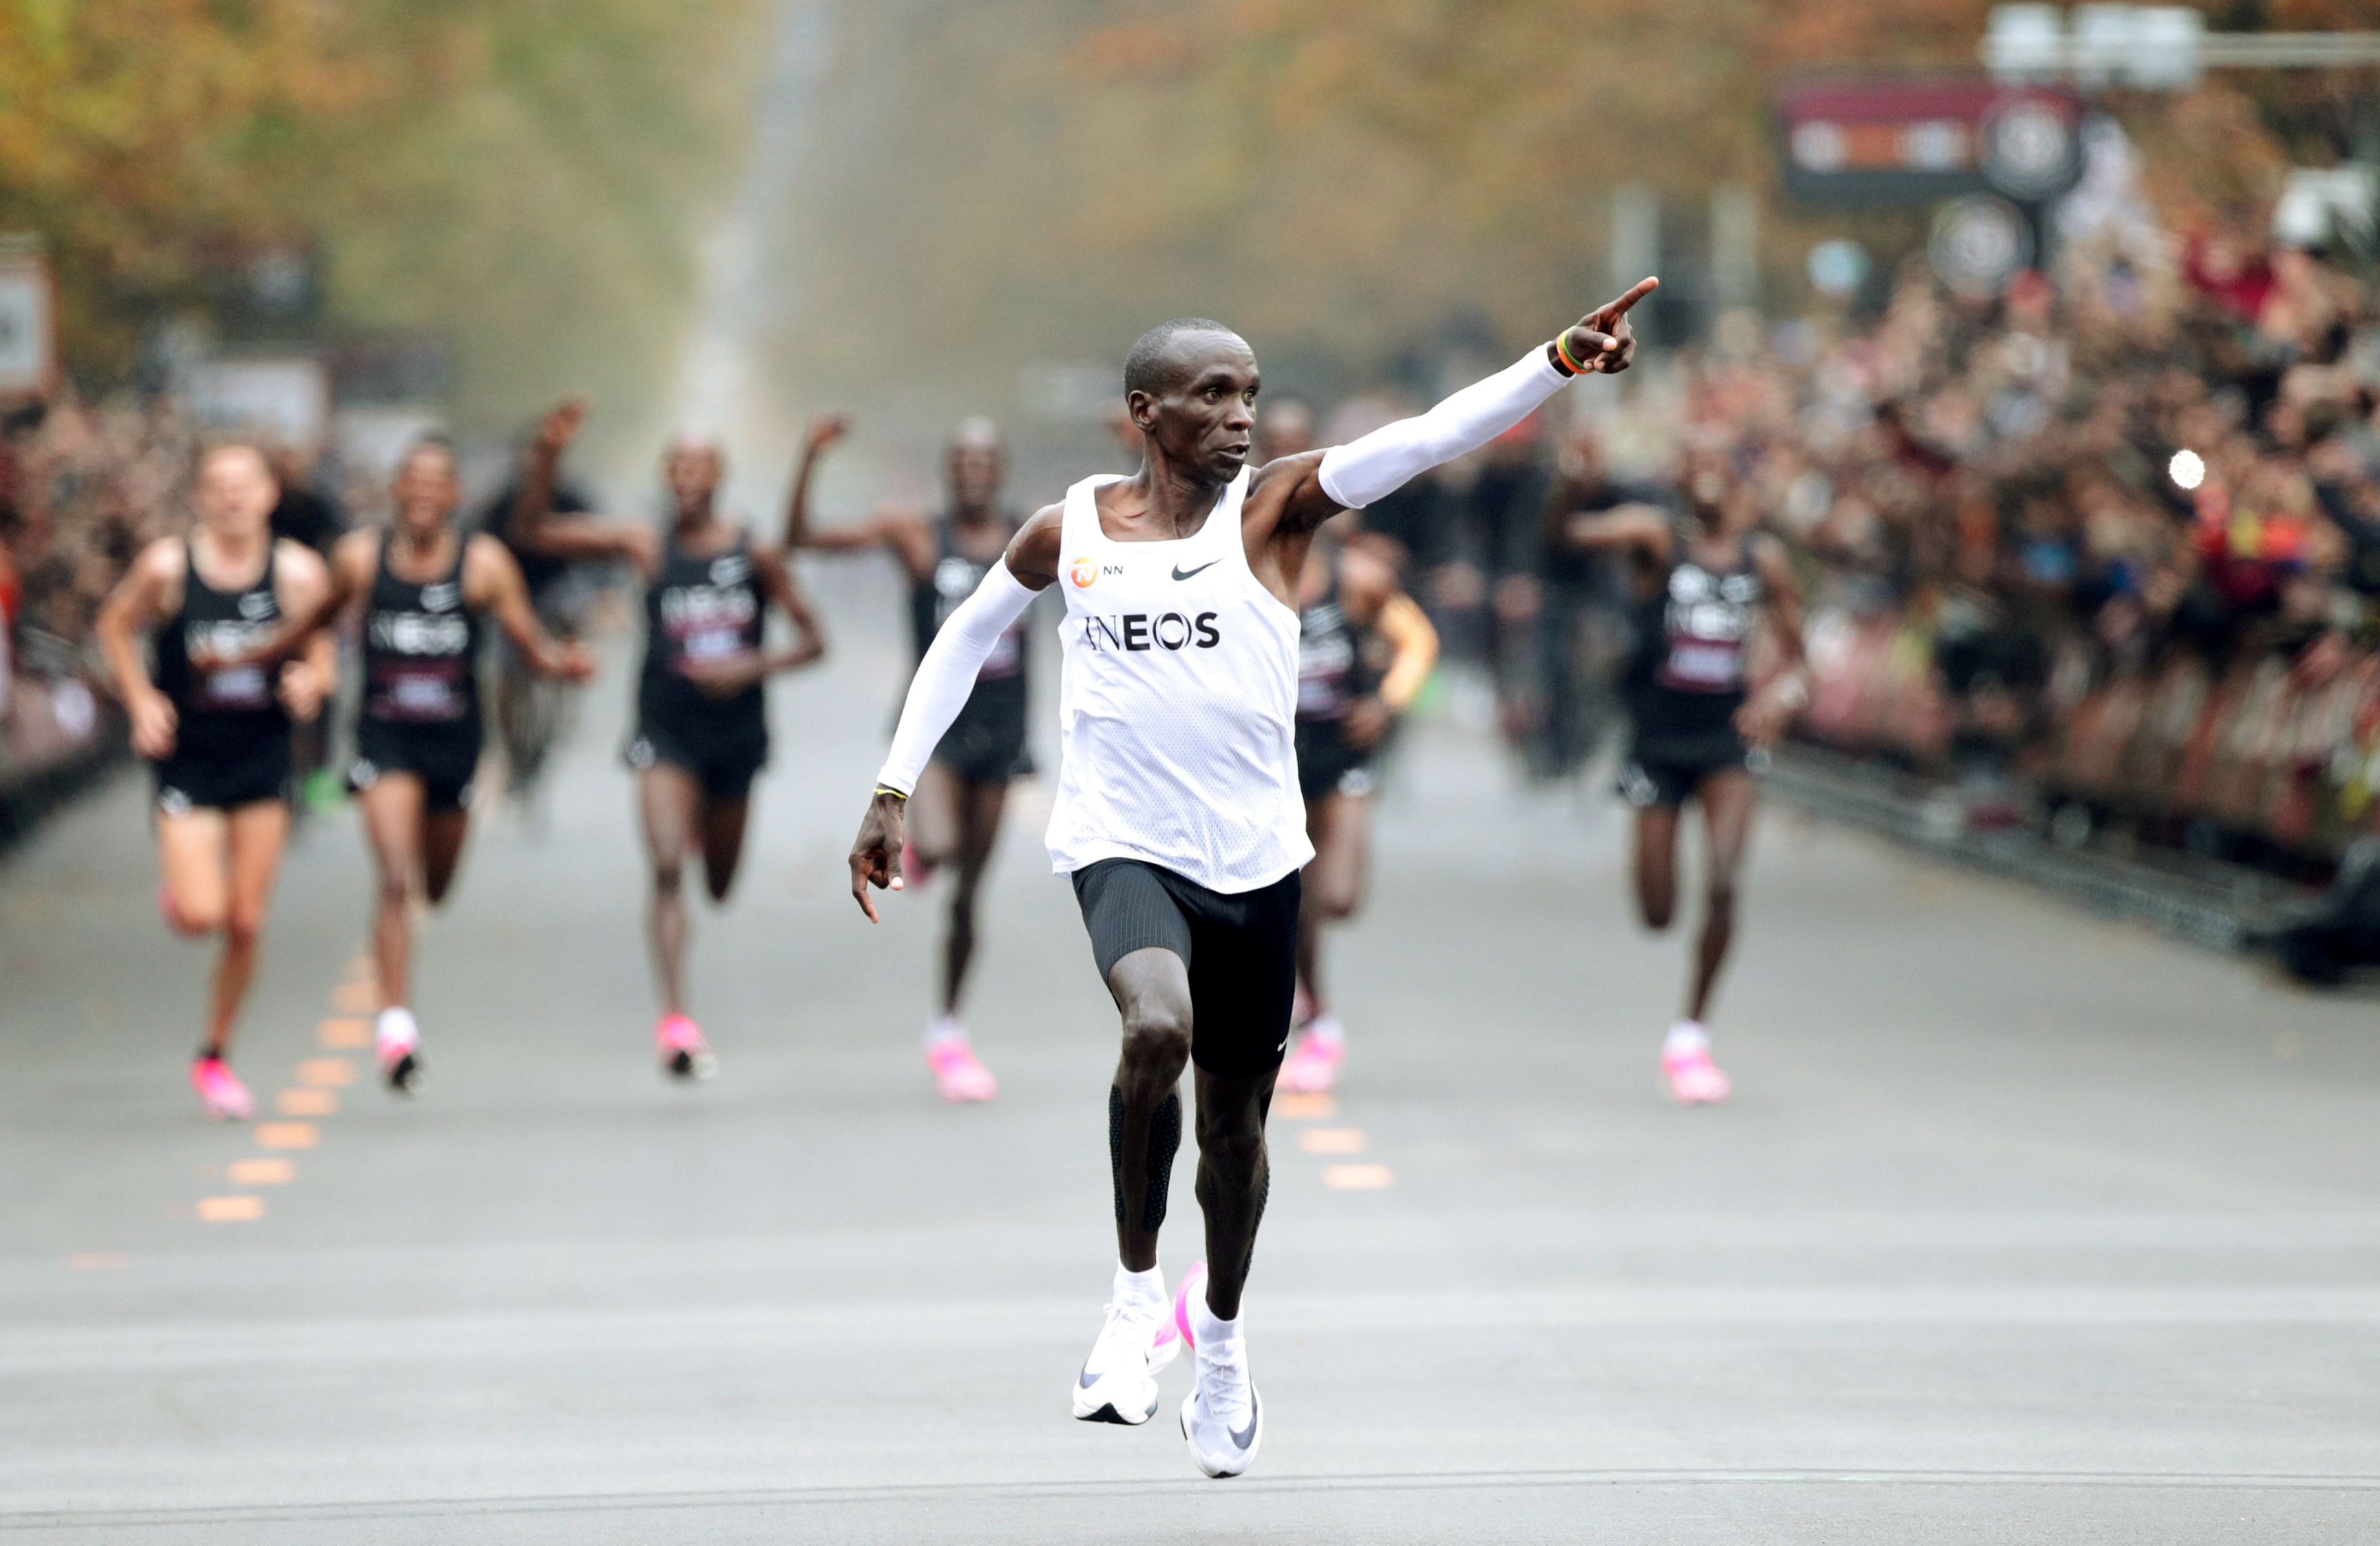

In [3]:
Image(filename='kipchoge_winning.png')

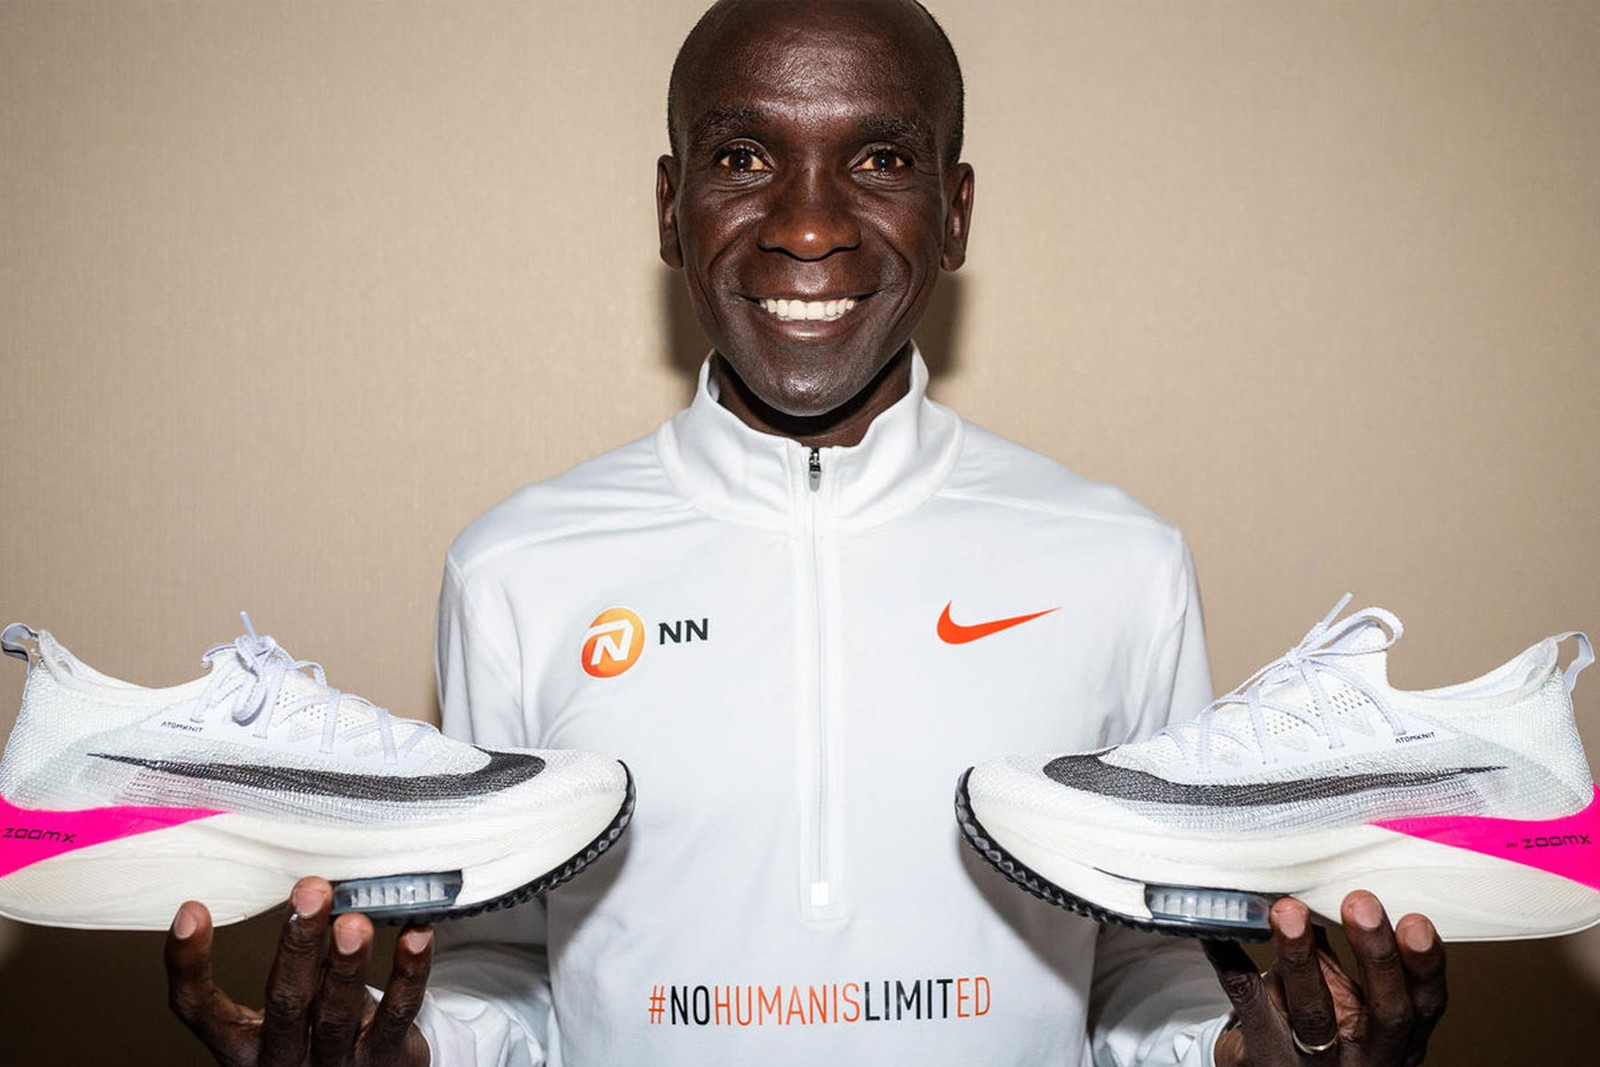

In [4]:
Image(filename='kipchoge.png')

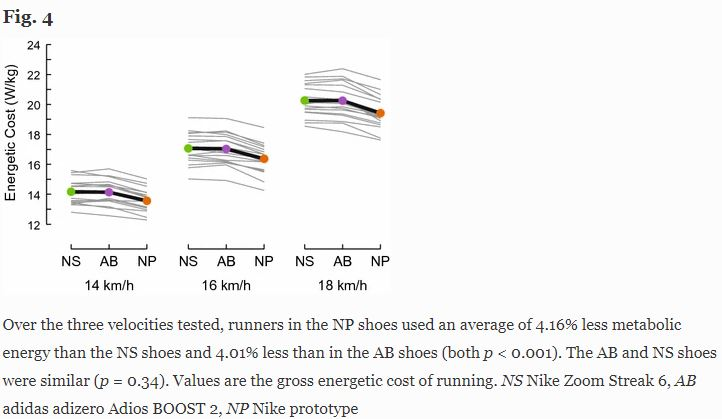

In [5]:
Image(filename='4_percent.png')

source: https://link.springer.com/article/10.1007%2Fs40279-017-0811-2

## Thus the name 'Nike 4%' was born. Regulators took some time to catch up to the new technology, but the rulebook has been rewritten and now the other major players in running shoes have comparable road racing shoes on the market.  

### Old Spikes

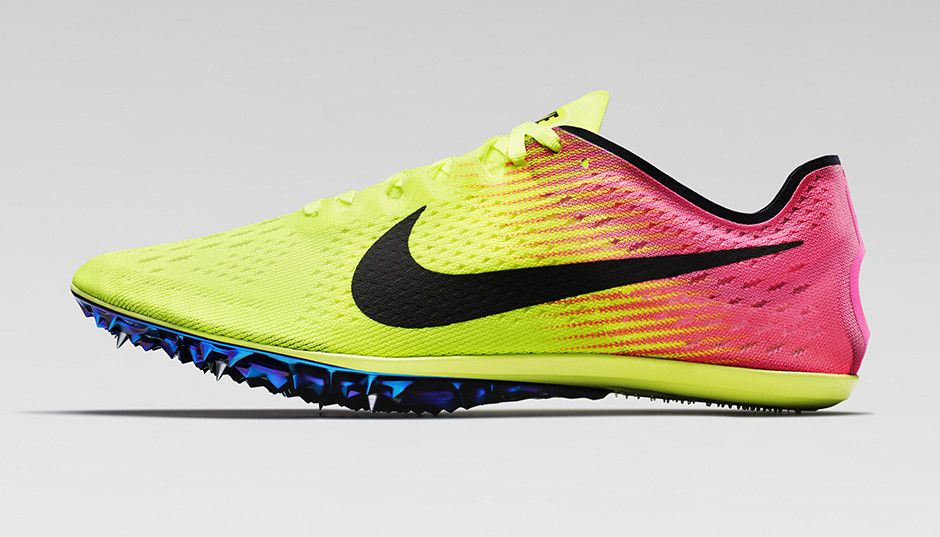

In [6]:
Image(filename='nike_zoom_vic.png')

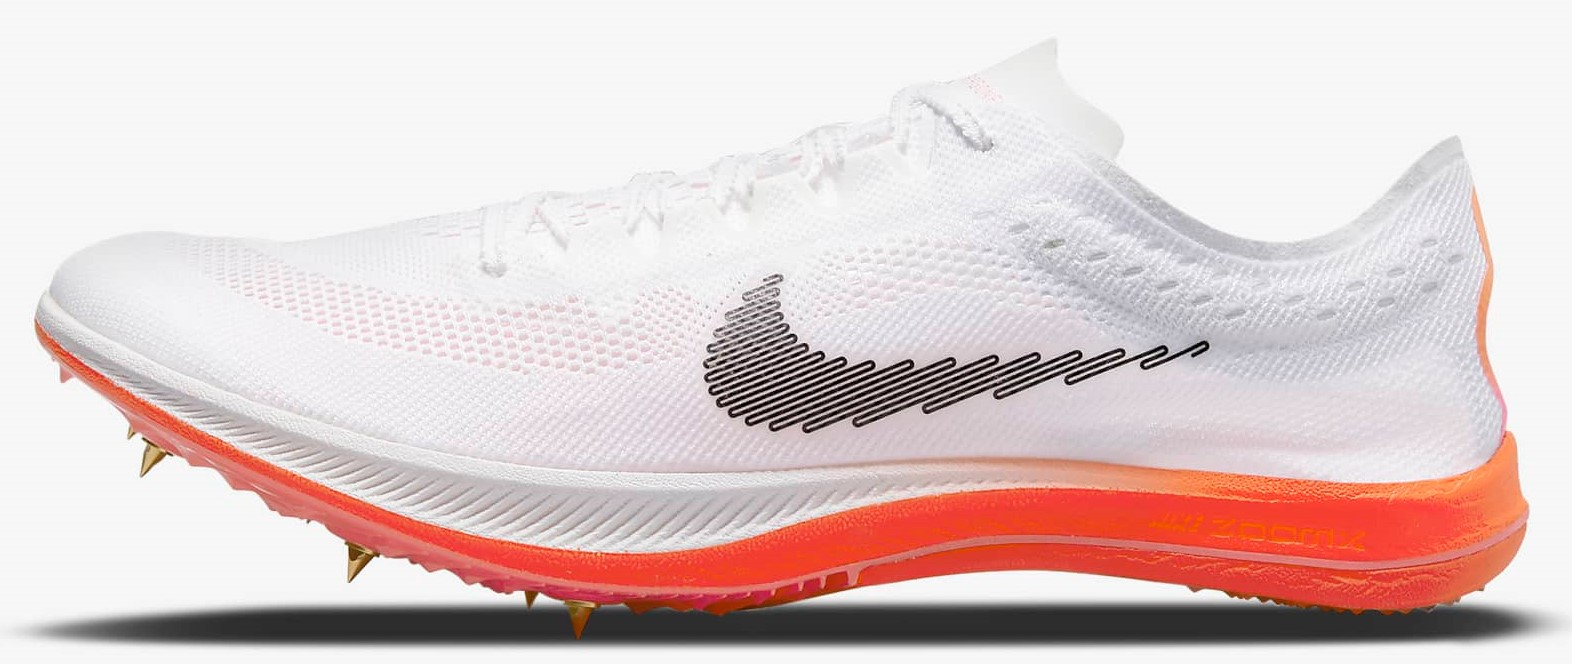

In [7]:
Image(filename='zoomx_1.png')

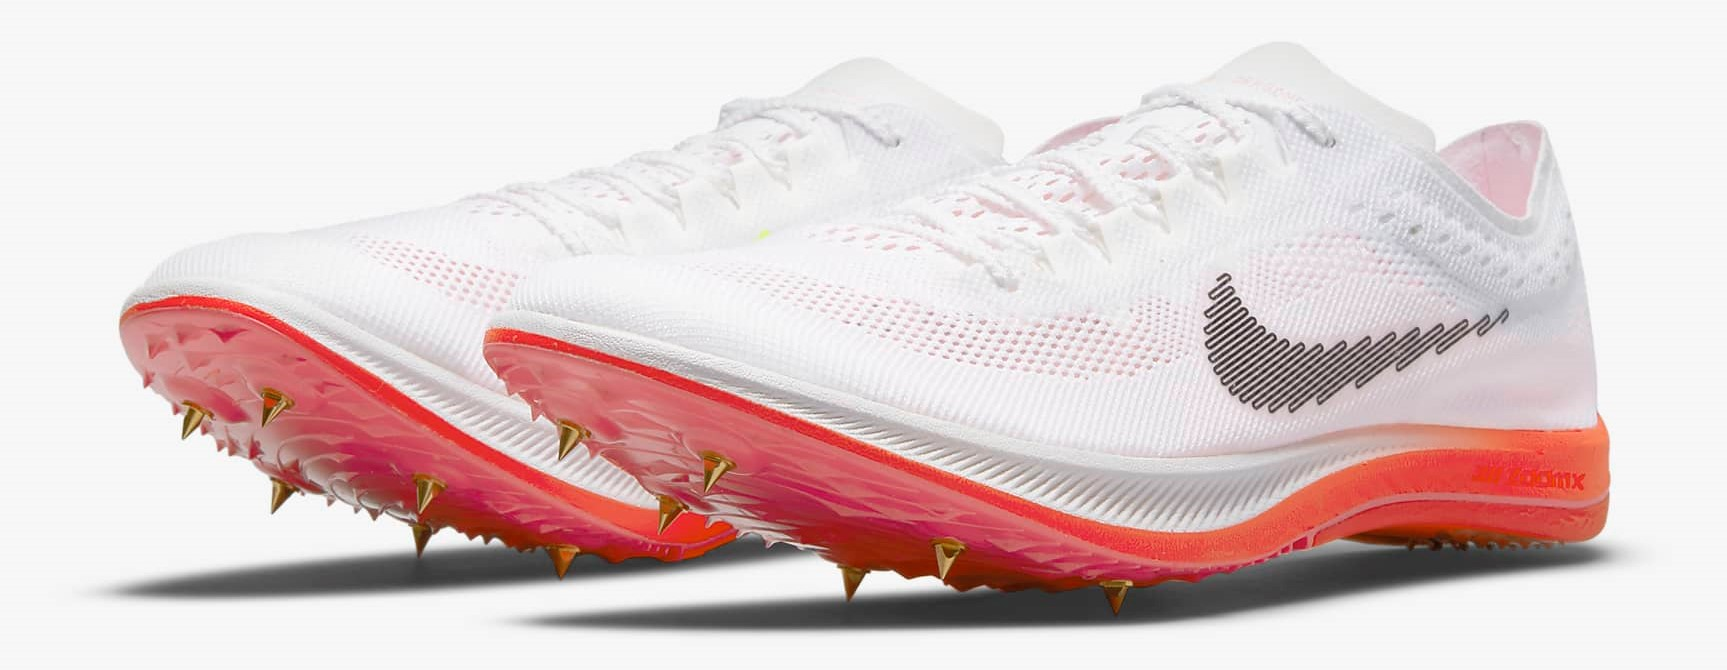

In [8]:
Image(filename='zoomx_2.png')

## Identification
The track spike technology for sprinting events was not approved for competition, while the spikes for distance events were approved.  <br>
This allows us to use sprinting events as a control, and access to super shoes as the treatment.  <br>
source: https://www.runnersworld.com/uk/news/a35585698/nike-viperfly-shelved/

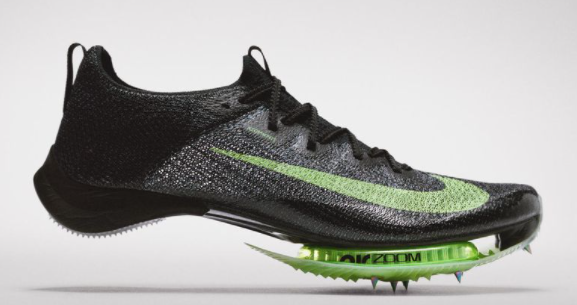

In [9]:
Image(filename='viperfly.png')

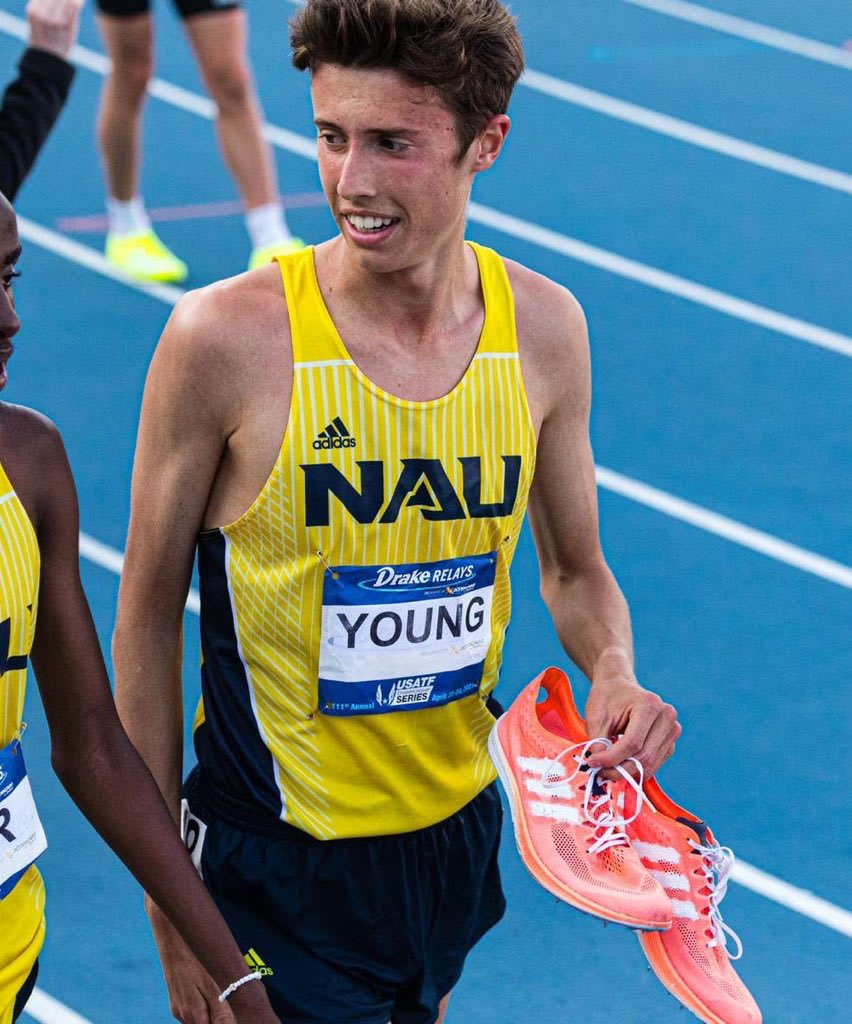

In [10]:
Image(filename='nau_adi_spike.png')

## Data and EDA
Data is gathered from the TFRRS.org archive.  Includes data from 2010-2021 (excluding 2020) for top 100 regular season performances for each running event contested for men and women in Division I, II and III. 

In [11]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ks_2samp
from scipy.optimize import curve_fit
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm
import datetime
import itertools

import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [12]:
# https://www.youtube.com/watch?v=EgIU1_qZ5Lcabs

In [242]:
# read in data from csv and convert column names to str
df100 = pd.read_csv('tfrrs_scraped.csv')

# keep only running events
running_events = ['100', '200', '400', '800', '1500', '5000', '10000', '100H',
       '110H', '400H', '3000S', '4x100', '4x400']
df100 = df100[df100['EVENT'].isin(running_events)]

In [243]:
df100.head()

POSITION  CHAMP_YEAR DIVISION EVENT  SEX             ATHLETE  YEAR  \
0         1        2021       D1   100  Men     Laird, Terrance  JR-3   
1         2        2021       D1   100  Men  Maswanganyi, Shaun  FR-1   
2         3        2021       D1   100  Men    Martin, JoVaughn  SO-2   
3         4        2021       D1   100  Men     Boling, Matthew  FR-1   
4         5        2021       D1   100  Men       Amoah, Joseph  SR-4   

            TEAM   TIME  TIME_SECS MARK CONV  POINTS  \
0            LSU   9:80       9.80  NaN  NaN     NaN   
1        Houston   9:87       9.87  NaN  NaN     NaN   
2  Florida State   9:94       9.94  NaN  NaN     NaN   
3        Georgia   9:97       9.97  NaN  NaN     NaN   
4   Coppin State  10:00      10.00  NaN  NaN     NaN   

                                               MEET     MEET DATE  
0           SEC Outdoor Track & Field Championships  May 13, 2021  
1  The American Outdoor Track & Field Championships  May 14, 2021  
2                         UF Tom Jones Invitational  Apr 16, 2021  
3           SEC Outdoor Track & Field Championships  May 13, 2021  
4                           2021 Aggie Invitational  Apr 10, 2021

# Visualizations

In [244]:
# queried list of dfs, one for each year

def query_each_year(df, division, sex, event):
    '''Takes df, returns list of dfs for each year with given parameters.'''
    
    results = []
    for year in df.CHAMP_YEAR.unique():
        new_df = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)]
        results.append(new_df)
    return results

In [245]:
# use queried list of dfs for each year to create a histogram for each year

def histograms_each_year(df, division, sex, event):
    '''Creates a histogram for each df in df_list after query constraints'''
    
    df_list = query_each_year(df, division, sex, event)
    
    for df in df_list:
        fig, ax = plt.subplots()
        plot = df.TIME_SECS.plot(kind='hist', bins=15, ax=ax)
        plot = plot.set_xticklabels(df['TIME'], rotation=20)
        plt.gcf().set_size_inches(8,5)
        pl.suptitle(str(df.CHAMP_YEAR.iloc[0]) + ' ' + df.SEX.iloc[0] + '\'s ' + df.EVENT.iloc[0])

### Example: lets make histograms for D1 men's 1500

In [246]:
def hist_density_overlap(df, division, sex, event):
    '''Creates an overlapping histogram and density for each df in queried list of dfs for each year'''
    
    df_list = query_each_year(df, division, sex, event)
    
    for df in df_list:
        plot = sns.distplot(df.TIME_SECS, kde=True, bins=15, hist=True, label=df.CHAMP_YEAR.iloc[0])
        plot = plot.set_xticklabels(df['TIME'], rotation=20)
        plt.legend()
        plt.gcf().set_size_inches(20,12)
        pl.suptitle(division + ' ' + sex + '\'s ' + event)

C:\Users\Adam\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-246-a4b2f441594b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot = plot.set_xticklabels(df['TIME'], rotation=20)
C:\Users\Adam\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-246-a4b2f441594b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot = plot.s

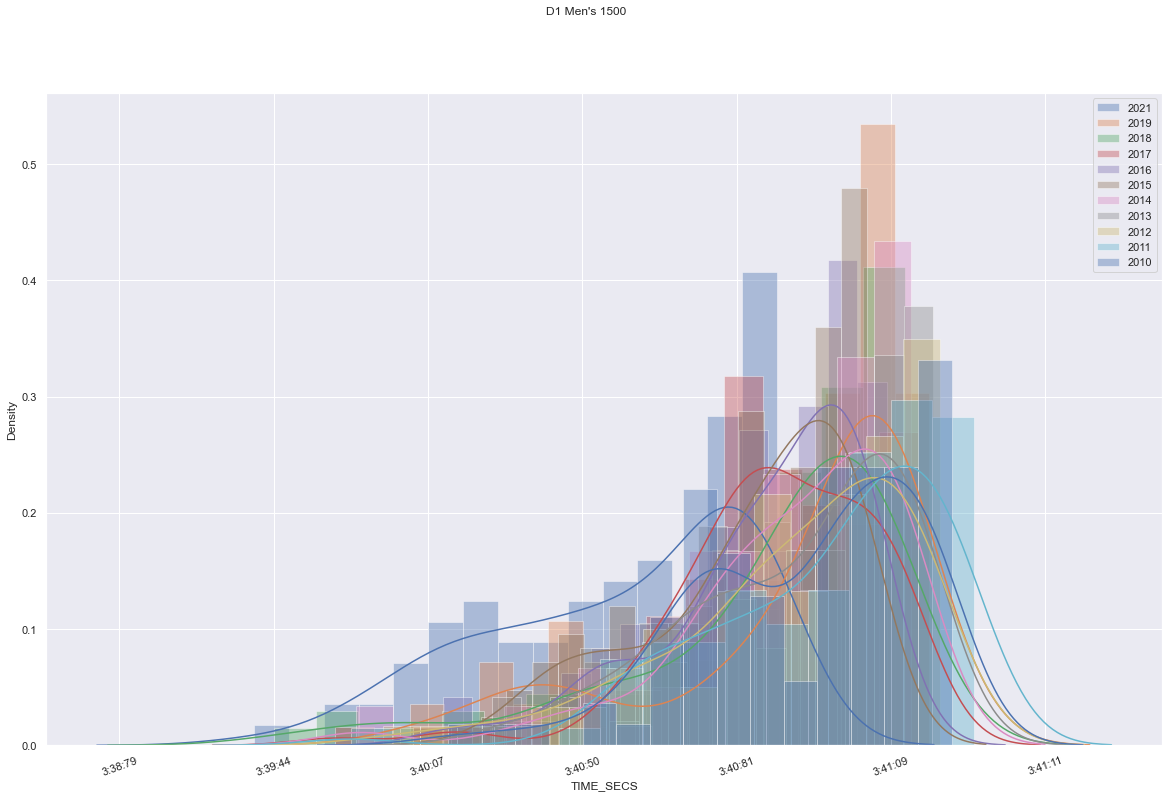

In [247]:
hist_density_overlap(df100, 'D1', 'Men', '1500')

In [248]:
hist_density_overlap(df100, 'D2', 'Women', '100')

IndexError: single positional indexer is out-of-bounds

### Time Trends

In [249]:
# separate df into 2021 and non 2021 years
df100_2021 = df100[df100['CHAMP_YEAR'] == 2021]
df100 = df100[df100['CHAMP_YEAR'] != 2021]

In [250]:
# function to convert seconds to time format
def convert_seconds(secs):
    '''Takes a total number of seconds and returns in %M:%S.%f format'''
    date = datetime.datetime.utcfromtimestamp(secs)
    output = datetime.datetime.strftime(date, "%M:%S.%f")
    return output

In [251]:
# mean for event in 2021
def mean_event_2021(division, sex, event):
    '''Returns the averagze TIME_SECS for given division sex and event in year 2021'''
    return df100_2021[(df100_2021['DIVISION'] == division) & (df100_2021['SEX'] == sex) & (df100_2021['EVENT'] == event)].TIME_SECS.mean()

In [252]:
def event_desc_each_year(df, division, sex, event):
    '''Returns a dataframe of summary stats of TIME_SECS for each year for given division, sex and event.  
    Plots a regplot with 95% confidence interval for 2010-2019 mean observations in blue and the 2021 mean observation in red.'''
    
    series_list = []
    for year in df.CHAMP_YEAR.unique():
        df_desc = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)].TIME_SECS.describe(percentiles=[0.2, 0.4, 0.6, 0.8])        
        series_list.append(df_desc)
        
    result = pd.DataFrame(series_list, index=df.CHAMP_YEAR.unique())
    result['CONVERT'] = [convert_seconds(x) for x in result['mean']]
    
    # plot
    fig, ax = plt.subplots()
    plot = sns.regplot(data = result.reset_index(), x = 'index', y = 'mean', ci=95).set_title(division + ' ' + sex + '\'s ' + event)
    plot.yticks=result['CONVERT']
    
    plt.gcf().set_size_inches(10,6)
    
    # add 2021 mean datapoint to plot as a red dot
    #plt.scatter(x=2021, y=mean_event_2021(division, sex, event), color='r')
    #return result

In [253]:
# create pre-treat df
df_pre_treat = df100[df100['CHAMP_YEAR'] < 2021]

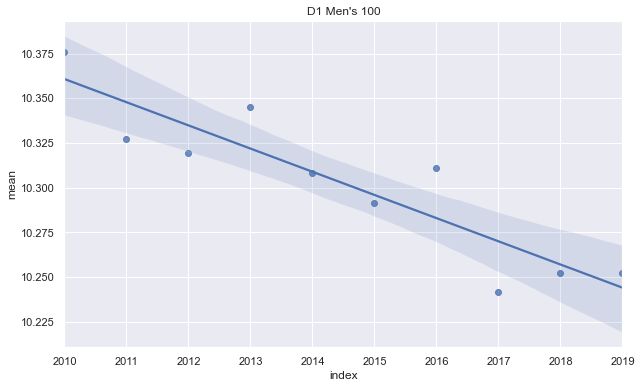

In [254]:
df_descD1men1500 = event_desc_each_year(df_pre_treat, 'D1', 'Men', '100')

In [255]:
df_descD1men1500 = event_desc_each_year(df_pre_treat, 'D2', 'Women', '5000')

ValueError: Invalid value NaN (not a number)

In [256]:
df_descD1men1500 = event_desc_each_year(df_pre_treat, 'D3', 'Men', '400')

ValueError: Invalid value NaN (not a number)

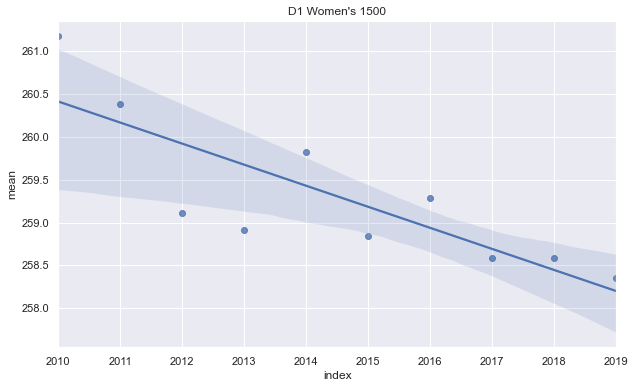

In [257]:
df_descD1men1500 = event_desc_each_year(df_pre_treat, 'D1', 'Women', '1500')

### Group by distance/sprint and run t-test to see if slopes are statistically different.

In [258]:
# new dfs for dist/sprints with log time secs to use for slope comparison
distance_events = ['800', '10000', '1500', '3000S','5000']
dist_df = df_pre_treat[df_pre_treat['EVENT'].isin(distance_events)]
sprint_df = df_pre_treat[~df_pre_treat['EVENT'].isin(distance_events)]

# add log_time_secs to both dfs
dist_df['TIME_SECS'] = dist_df['TIME_SECS'].apply(lambda x: np.log(x))
sprint_df['TIME_SECS'] = sprint_df['TIME_SECS'].apply(lambda x: np.log(x))

<ipython-input-258-9f34f25ef81b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist_df['TIME_SECS'] = dist_df['TIME_SECS'].apply(lambda x: np.log(x))
<ipython-input-258-9f34f25ef81b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sprint_df['TIME_SECS'] = sprint_df['TIME_SECS'].apply(lambda x: np.log(x))


In [259]:
def regroup_df(df):
    '''group by CHAMP_YEAR DIVISION EVENT SEX'''
    df_group = df.groupby(['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX']).mean()
    group = df_group['TIME_SECS'].groupby(['EVENT', 'DIVISION'], group_keys=False)
    res = group.apply(lambda x: x.sort_values(ascending=[False]))
    
    return pd.DataFrame(res).reset_index()

In [260]:
dist_df = regroup_df(dist_df)

In [261]:
sprint_df = regroup_df(sprint_df)

### Regression for time trends

In [262]:
# functions to get the slope, coef of determination, pvalue and std errors for two arrays
def reg_slope(X,y):
    '''Return stats.linregress slope for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[0]

def reg_rval(X,y):
    '''Return stats.linregress p-value for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[2]

def reg_pval(X,y):
    '''Return stats.linregress p-value for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[3]

def reg_stderr(X,y):
    '''Return stats.linregress standard error for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[4]

In [263]:
def reg_table(df):
    '''Take top 10 rows of dataframe: regress TIME_SECS on CHAMP_YEAR, predict 2021 and save the results to new df.'''
    results_list = []
    while len(df) > 0:
        
        years = [df.CHAMP_YEAR[i] for i in range(10)]
        means = [df.TIME_SECS[i] for i in range(10)]
        
        slope = reg_slope(years,means)
        rval = reg_rval(years,means)
        pval = reg_pval(years,means)
        std_err = reg_stderr(years,means)
        
        X = np.array(years).reshape(-1, 1)
        y = means

        reg = LinearRegression().fit(X, y)
        pred = reg.predict(np.array(2021).reshape(-1,1))[0]
        
        

        row_result = [str(df.DIVISION[0]), str(df.SEX[0]), str(df.EVENT[0]), slope, rval, pval, std_err, pred]
        results_list.append(row_result)
        
        df = df.drop(range(0,10))
        df = df.reset_index(drop=True)
    return pd.DataFrame(results_list, columns=['DIVISION', 'SEX', 'EVENT', 'SLOPE', 'R_VAL','P_VAL', 'STD_ERR', '2021_PRED'])

In [264]:
def pred_interval(means_list, prediction, critical_value = 1.96):
    sum_errs = arraysum((y - yhat)**2)
    stdev = sqrt(1/(len(y)-2) * sum_errs)

In [265]:
# create regression tables and desc df
sprint_results = reg_table(sprint_df)
dist_results = reg_table(dist_df)
sprint_slopes = sprint_results.SLOPE.describe()
dist_slopes = dist_results.SLOPE.describe()

desc = pd.concat([sprint_slopes, dist_slopes], axis=1)
desc.columns = ['Sprint Slopes', 'Distance Slopes']

desc

Sprint Slopes  Distance Slopes
count      14.000000        10.000000
mean       -0.001157        -0.000963
std         0.000477         0.000649
min        -0.001963        -0.002066
25%        -0.001465        -0.001360
50%        -0.001249        -0.000783
75%        -0.000713        -0.000441
max        -0.000429        -0.000341

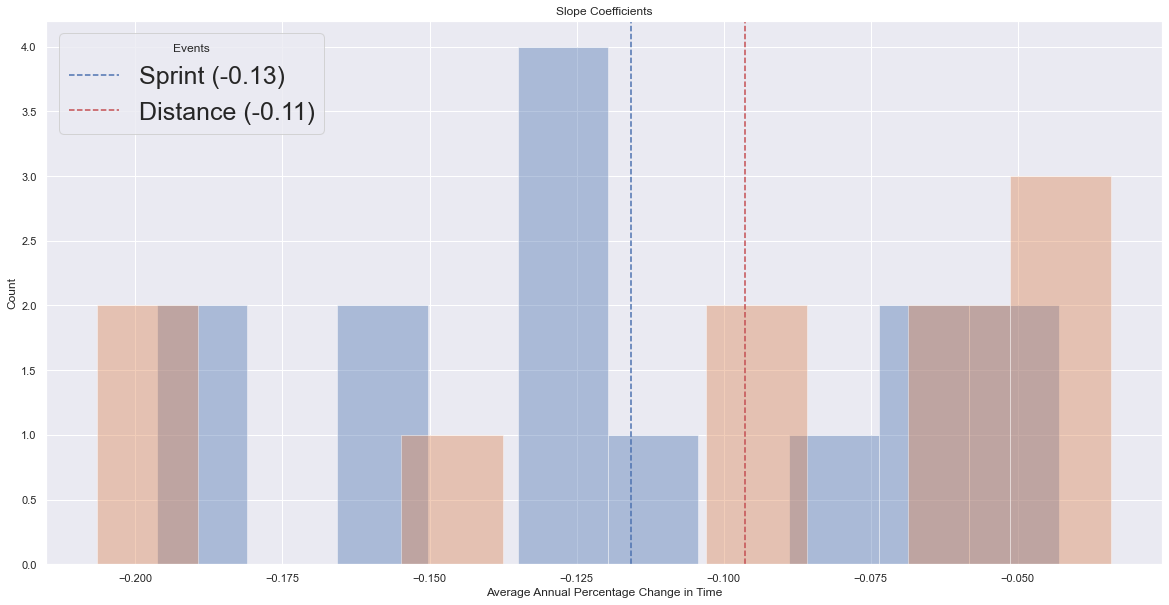

In [266]:
# plot the distribution of the slopes for sprinting vs distance
plt.hist(sprint_results['SLOPE']*100, alpha=0.4)
plt.hist(dist_results['SLOPE']*100, alpha=0.4)
plt.title('Slope Coefficients')
plt.xlabel('Average Annual Percentage Change in Time')
plt.ylabel('Count')
plt.axvline(x=sprint_results.SLOPE.mean()*100, color='b', linestyle = '--')
plt.axvline(x=dist_results.SLOPE.mean()*100, color='r', linestyle = '--', label='Treatment')

plt.legend(['Sprint (-0.13)', 'Distance (-0.11)'], loc='upper left', title='Events', prop={'size': 25})
plt.show()
plt.rcParams['figure.figsize'] = [15,10]

### 2021 Observation Compared to Trends

In [267]:
def event_desc_each_year(df, division, sex, event):
    '''Returns a dataframe of summary stats of TIME_SECS for each year for given division, sex and event.  
    Plots a regplot with 95% confidence interval for 2010-2019 mean observations in blue and the 2021 mean observation in red.'''
    
    series_list = []
    for year in df.CHAMP_YEAR.unique():
        df_desc = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)].TIME_SECS.describe(percentiles=[0.2, 0.4, 0.6, 0.8])        
        series_list.append(df_desc)
        
    result = pd.DataFrame(series_list, index=df.CHAMP_YEAR.unique())
    result['CONVERT'] = [convert_seconds(x) for x in result['mean']]
    
    # plot
    fig, ax = plt.subplots()
    plot = sns.regplot(data = result.reset_index(), x = 'index', y = 'mean', ci=95).set_title(division + ' ' + sex + '\'s ' + event)
    plot.yticks=result['CONVERT']
    
    plt.gcf().set_size_inches(10,6)
    
    # add 2021 mean datapoint to plot as a red dot
    plt.scatter(x=2021, y=mean_event_2021(division, sex, event), color='r')
    return result

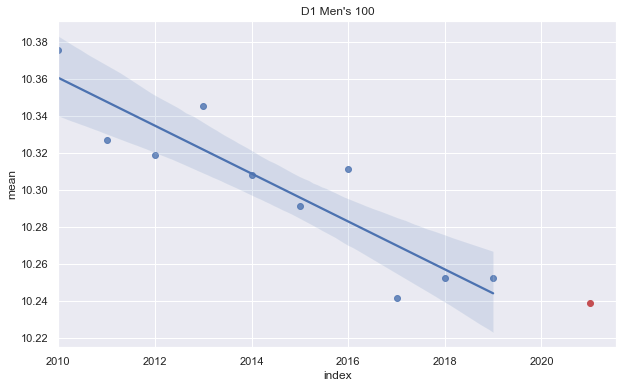

In [268]:
df_descD1men1500 = event_desc_each_year(df_pre_treat, 'D1', 'Men', '100')

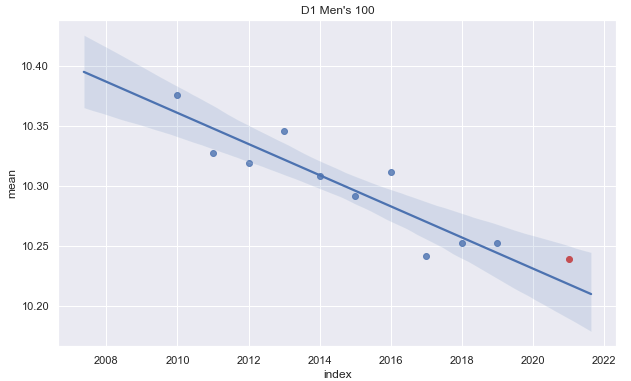

In [269]:
Image(filename='d1men100.png')

In [270]:
df_descD1men1500 = event_desc_each_year(df_pre_treat, 'D2', 'Men', '110H')

ValueError: Invalid value NaN (not a number)

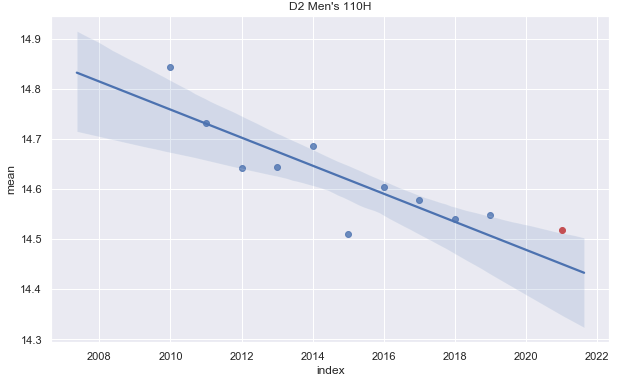

In [271]:
Image(filename='d2men110h.png')

In [272]:
df_descD1men1500 = event_desc_each_year(df_pre_treat, 'D3', 'Women', '100H')

ValueError: Invalid value NaN (not a number)

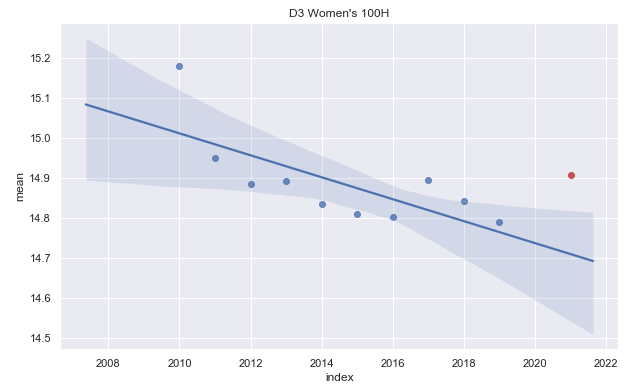

In [273]:
Image(filename='d3women.png')

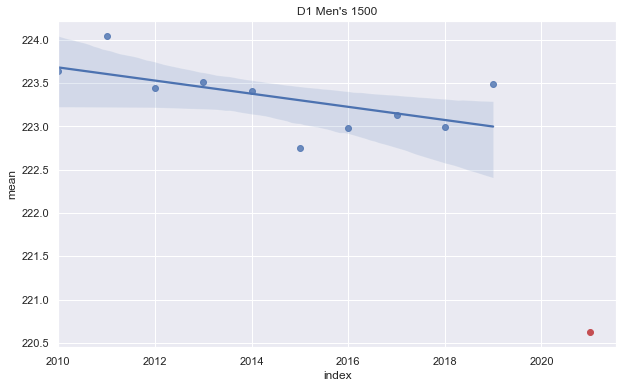

In [274]:
df_descD1men1500 = event_desc_each_year(df_pre_treat, 'D1', 'Men', '1500')

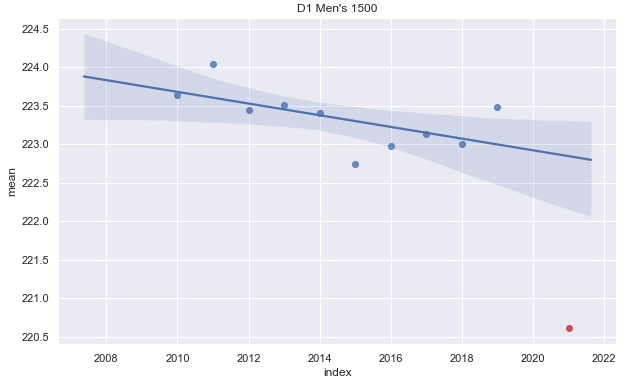

In [275]:
Image(filename='d1men1500.png')

In [276]:
df_descD1men1500 = event_desc_each_year(df_pre_treat, 'D2', 'Men', '5000')

ValueError: Invalid value NaN (not a number)

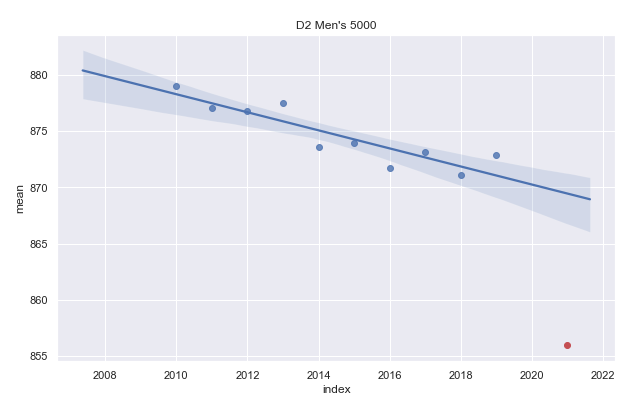

In [277]:
Image(filename='d2men5000.png')

### Compare 2021 Prediction to Observed
How many of the actual 2021 observations fall outside of the predicted confidence interval?

In [278]:
results = pd.read_csv('pred_vs_actual.csv')

In [279]:
results

95% Signif. Distance Sprinting  99% Signif. Distance.1 Sprinting.1
0          Reject        8         3          NaN          5           2
1  Fail to Reject       16        45          NaN         19          46
2  Percent Reject   33.33%     6.25%          NaN     20.83%       4.17%
3           Ratio     5.33       NaN          NaN          5         NaN

### Synthetic control and treatment variables

In [382]:
# read in data from csv and convert column names to str
df100 = pd.read_csv('tfrrs_scraped.csv')

# keep only running events
running_events = ['100', '200', '400', '800', '1500', '5000', '10000', '100H',
       '110H', '400H', '3000S', '4x100', '4x400']
df100 = df100[df100['EVENT'].isin(running_events)]

df100 = df100[df100['DIVISION'].isin(['D1', 'D2'])]

In [383]:
# create new df. For each year/division/event/sex group, get the average time_secs for that group in each year

# list of groups and avg time_secs
avg_list = []
for group in df100.groupby(['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX']):
    avg_list.append([group[0], group[1].TIME_SECS.mean()])
    
# split group tuple back into year/division/event/sex columns and drop group tuple
df_grouped = pd.DataFrame(avg_list, columns = ['GROUP', 'TIME_SECS_AVG'])
df_grouped[['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX']] = pd.DataFrame(df_grouped['GROUP'].tolist(), index=df_grouped.index)
df_grouped = df_grouped[['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX', 'TIME_SECS_AVG']]

In [384]:
# list of dfs for each division/event/sex group
df_list = [group[1].reset_index() for group in df_grouped.groupby(['DIVISION', 'EVENT', 'SEX'])]

# for each df, rescale the TIME_SECS column by dividing all by the 2010 avg
avg_2010 = [df['TIME_SECS_AVG'][0] for df in df_list]
for df,avg in zip(df_list,avg_2010):
    df['TIME_SECS_SCALED'] = df['TIME_SECS_AVG']/avg
    
# concat back into one df
df_scaled = pd.concat(df_list).reset_index()
df_scaled.drop(['level_0','index'], axis=1, inplace=True)

In [385]:
# add treat, after and treatafter variable to the df
distance = ['800', '1500', '5000', '10000', '3000S']
treat_list = [1 if event in distance else 0 for event in df_scaled['EVENT']]
df_scaled['TREAT'] = treat_list
df_scaled['AFTER'] = df_scaled['CHAMP_YEAR'] >= 2021
df_scaled['TREAT_AFTER'] = df_scaled['AFTER']*df_scaled['TREAT']

In [386]:
# create synthetic control for 2010-2019, non weighted scaled average for each year for non-treated groups
control_df = df_scaled[(df_scaled['TREAT'] == 0) & (df_scaled['CHAMP_YEAR'] < 2021)]

sc = pd.DataFrame([[group[0], group[1]['TIME_SECS_SCALED'].mean()] for group in control_df.groupby('CHAMP_YEAR')], columns=['CHAMP_YEAR', 'AVG_SCALED_SECS'])

In [387]:
# run log transformed regression to predict
xs = np.array(sc.CHAMP_YEAR).reshape(-1, 1)
log_ys = [np.log(x) for x in sc.AVG_SCALED_SECS]

reg = LinearRegression().fit(xs, log_ys)
pred = np.exp(reg.predict(np.array(2021).reshape(-1,1))[0])

sc = sc.append({'CHAMP_YEAR':2021, 'AVG_SCALED_SECS':pred}, ignore_index=True)
sc['CHAMP_YEAR'] = sc['CHAMP_YEAR'].astype(int)

    CHAMP_YEAR  AVG_SCALED_SECS
0         2010         1.000000
1         2011         0.995938
2         2012         0.993651
3         2013         0.994310
4         2014         0.993235
5         2015         0.990935
6         2016         0.989810
7         2017         0.987657
8         2018         0.987379
9         2019         0.988040
10        2021         0.983725


Text(0, 0.5, 'Average Time Relative to 2010 Average')

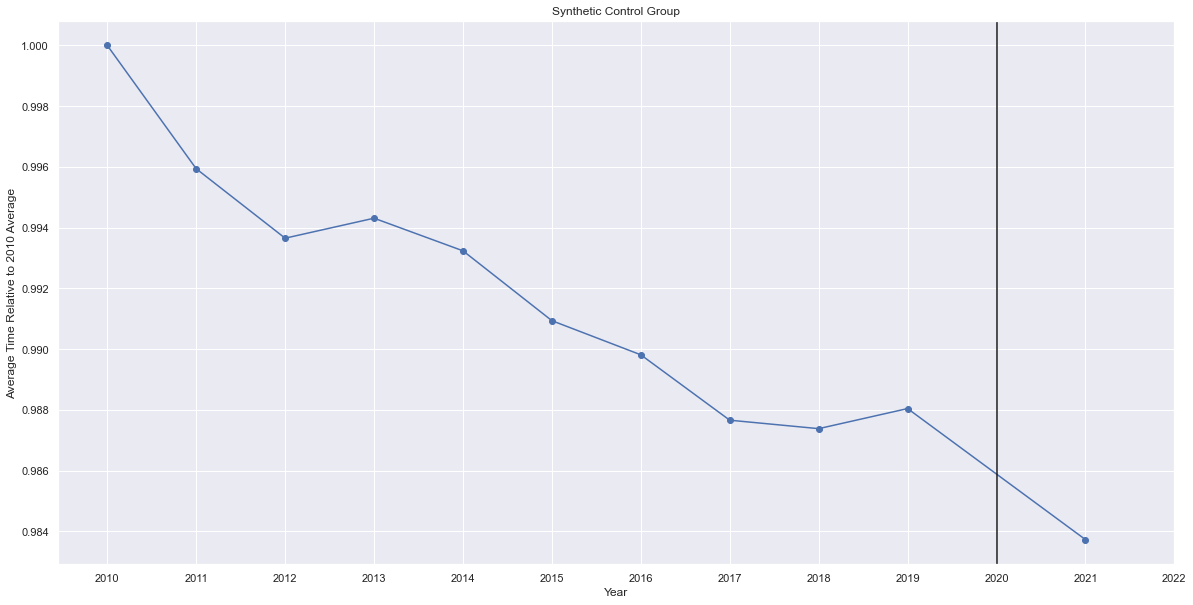

In [388]:
print(sc)
plt.plot(sc.CHAMP_YEAR, sc.AVG_SCALED_SECS, '-o');
plt.axvline(x=2020, color = 'k')
plt.title('Synthetic Control Group')
plt.xticks([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022])
plt.xlabel('Year')
plt.ylabel('Average Time Relative to 2010 Average')

In [389]:
#create list of dfs for treated groups and control groups
treat_df = df_scaled[df_scaled['TREAT'] == 1]
control_df = df_scaled[df_scaled['TREAT'] == 0]

treat_list = [group[1] for group in treat_df.groupby(['DIVISION', 'EVENT', 'SEX'])]
control_list = [group[1] for group in control_df.groupby(['DIVISION', 'EVENT', 'SEX'])]

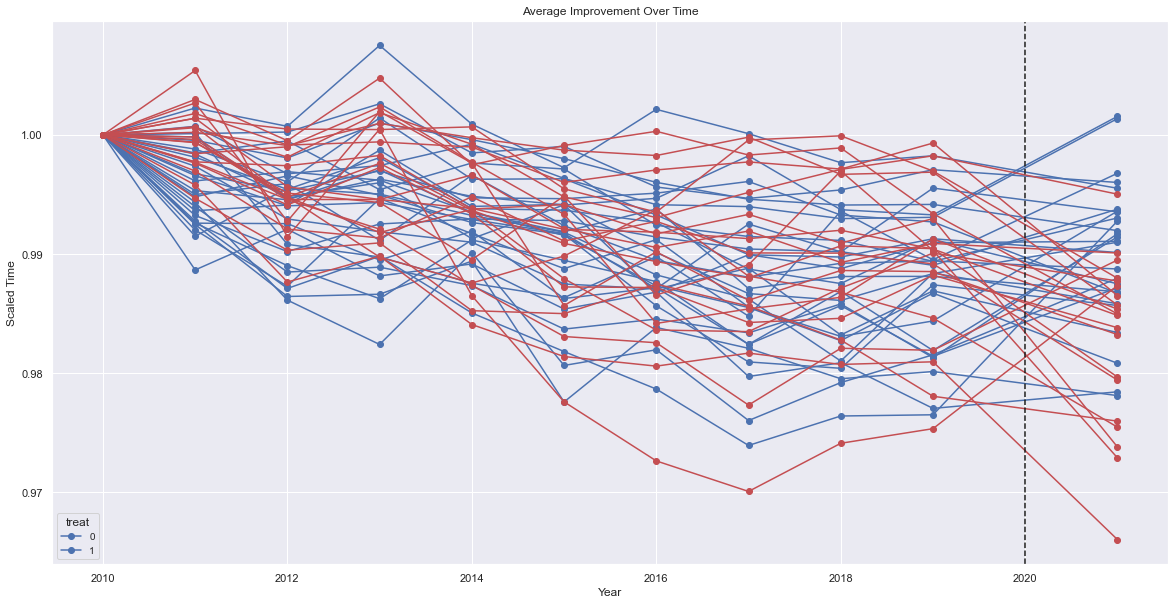

In [390]:
# plot scaled trends for each control and treated group

for group in control_list:
    id_ = group['DIVISION'].unique()[0] + ' ' + group['EVENT'].unique()[0] + ' ' + group['SEX'].unique()[0]
    plt.plot(group['CHAMP_YEAR'], group['TIME_SECS_SCALED'], '-bo', color = 'b', label = id_)

for group in treat_list:
    id_ = group['DIVISION'].unique()[0] + ' ' + group['EVENT'].unique()[0] + ' ' + group['SEX'].unique()[0]
    plt.plot(group['CHAMP_YEAR'], group['TIME_SECS_SCALED'], '-bo', color = 'r', label = id_)

plt.axvline(x=2020, color='k', linestyle = '--', label='Treatment')
plt.title('Average Improvement Over Time')
plt.xlabel('Year')
plt.ylabel('Scaled Time')
plt.legend([0,1], loc='lower left', title='treat', prop={'size': 10})
plt.rcParams['figure.figsize'] = [20,10]

plt.show()

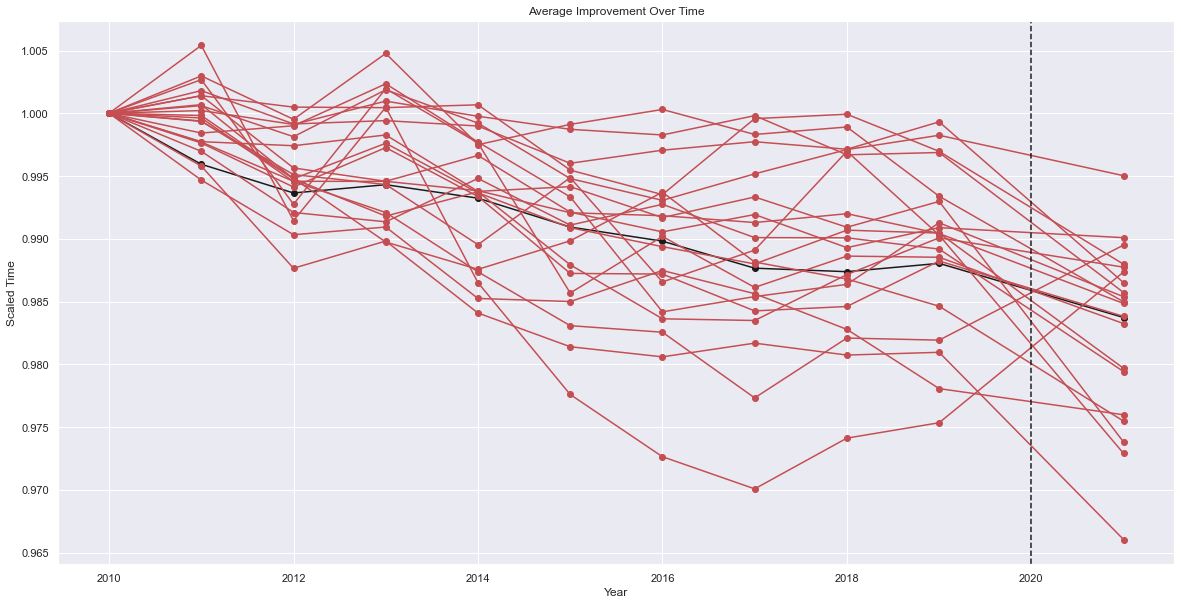

In [391]:
# plot scaled trends for synthetic control and each treated group

plt.plot(sc['CHAMP_YEAR'], sc['AVG_SCALED_SECS'], '-bo', color = 'k', label = id_)

for group in treat_list:
    id_ = group['DIVISION'].unique()[0] + ' ' + group['EVENT'].unique()[0] + ' ' + group['SEX'].unique()[0]
    plt.plot(group['CHAMP_YEAR'], group['TIME_SECS_SCALED'], '-bo', color = 'r', label = id_)

plt.axvline(x=2020, color='k', linestyle = '--', label='Treatment')
plt.title('Average Improvement Over Time')
plt.xlabel('Year')
plt.ylabel('Scaled Time')
# plt.legend([0,1,2,3], loc='lower left', title='treat', prop={'size': 10})
plt.rcParams['figure.figsize'] = [20,10]

plt.show()


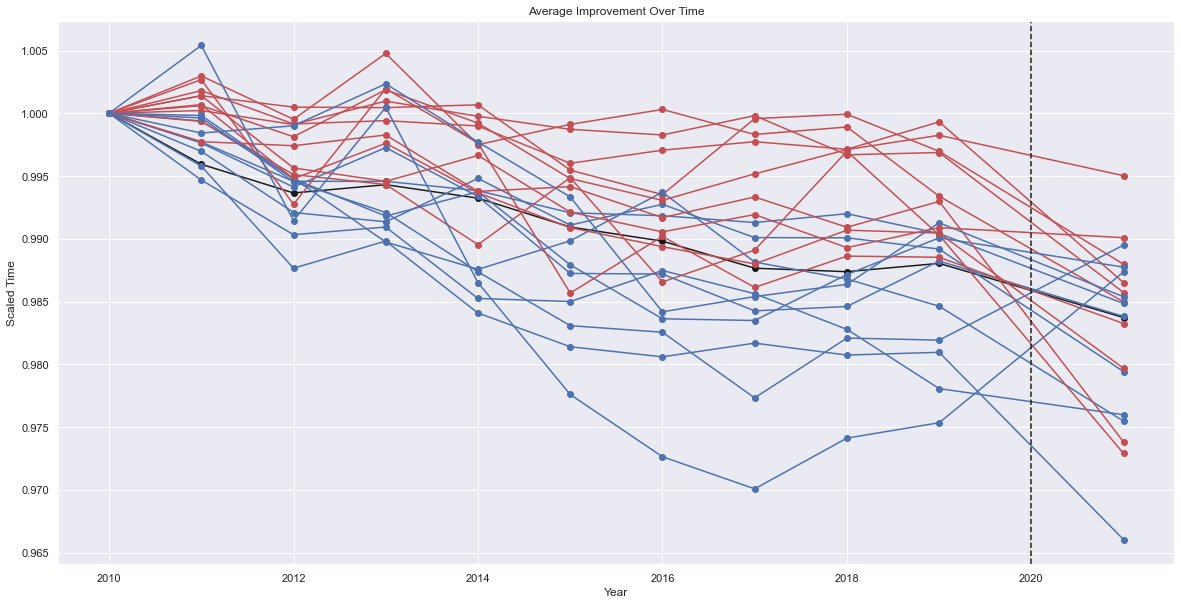

In [392]:
# plot scaled trends for synthetic control and each treated group, color by Sex

plt.plot(sc['CHAMP_YEAR'], sc['AVG_SCALED_SECS'], '-bo', color = 'k', label = id_)

for group in treat_list:
    if group['SEX'].iloc[0] == 'Men':
        plt.plot(group['CHAMP_YEAR'], group['TIME_SECS_SCALED'], '-bo', color = 'r')
    else:
        plt.plot(group['CHAMP_YEAR'], group['TIME_SECS_SCALED'], '-bo', color = 'b')

plt.axvline(x=2020, color='k', linestyle = '--', label='Treatment')
plt.title('Average Improvement Over Time')
plt.xlabel('Year')
plt.ylabel('Scaled Time')
# plt.legend([0,1], loc='lower left', title='treat', prop={'size': 10})
plt.rcParams['figure.figsize'] = [20,10]

plt.show()

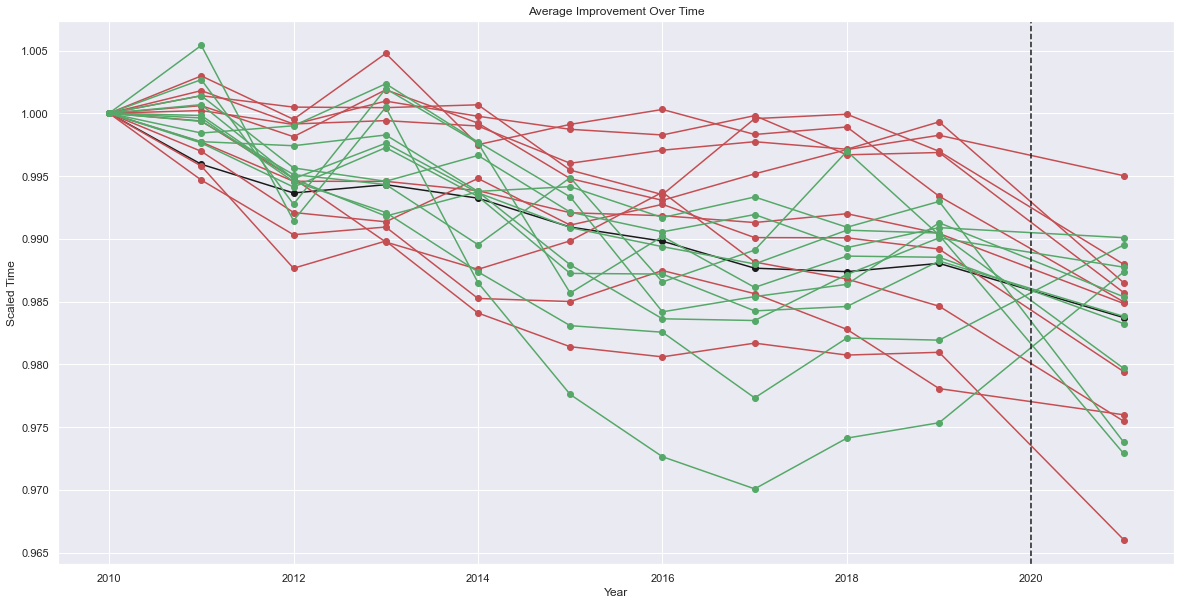

In [393]:
# plot scaled trends for synthetic control and each treated group, color by Division

plt.plot(sc['CHAMP_YEAR'], sc['AVG_SCALED_SECS'], '-bo', color = 'k', label = id_)

for group in treat_list:
    if group['DIVISION'].iloc[0] == 'D1':
        plt.plot(group['CHAMP_YEAR'], group['TIME_SECS_SCALED'], '-bo', color = 'r')
    elif group['DIVISION'].iloc[0] == 'D2':
        plt.plot(group['CHAMP_YEAR'], group['TIME_SECS_SCALED'], '-bo', color = 'g')
    else:
        plt.plot(group['CHAMP_YEAR'], group['TIME_SECS_SCALED'], '-bo', color = 'b')

plt.axvline(x=2020, color='k', linestyle = '--', label='Treatment')
plt.title('Average Improvement Over Time')
plt.xlabel('Year')
plt.ylabel('Scaled Time')
# plt.legend([0,1,2,3], loc='lower left', title='treat', prop={'size': 10})
plt.rcParams['figure.figsize'] = [20,10]

plt.show()

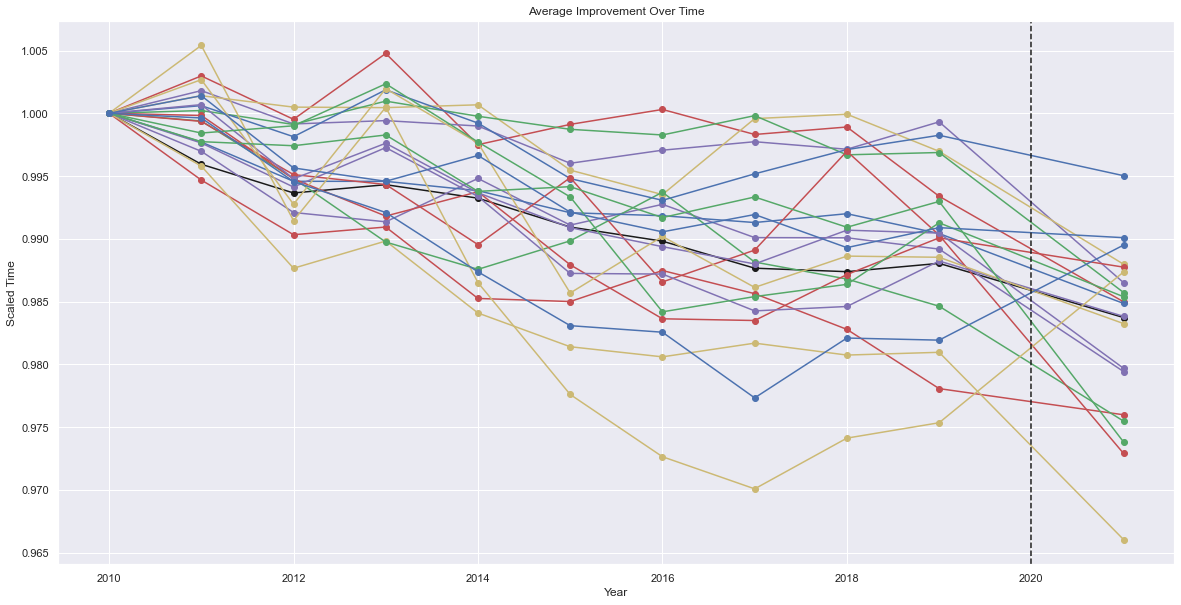

In [394]:
# plot scaled trends for synthetic control and each treated group, color by Event

plt.plot(sc['CHAMP_YEAR'], sc['AVG_SCALED_SECS'], '-bo', color = 'k', label = id_)

for group in treat_list:
    if group['EVENT'].iloc[0] == '10000':
        plt.plot(group['CHAMP_YEAR'], group['TIME_SECS_SCALED'], '-bo', color = 'r')
    elif group['EVENT'].iloc[0] == '5000':
        plt.plot(group['CHAMP_YEAR'], group['TIME_SECS_SCALED'], '-bo', color = 'g')
    elif group['EVENT'].iloc[0] == '3000S':
        plt.plot(group['CHAMP_YEAR'], group['TIME_SECS_SCALED'], '-bo', color = 'y')
    elif group['EVENT'].iloc[0] == '1500':
        plt.plot(group['CHAMP_YEAR'], group['TIME_SECS_SCALED'], '-bo', color = 'm')
    else:
        plt.plot(group['CHAMP_YEAR'], group['TIME_SECS_SCALED'], '-bo', color = 'b')

plt.axvline(x=2020, color='k', linestyle = '--', label='Treatment')
plt.title('Average Improvement Over Time')
plt.xlabel('Year')
plt.ylabel('Scaled Time')
# plt.legend([0,1], loc='lower left', title='treat', prop={'size': 10})
plt.rcParams['figure.figsize'] = [20,10]

plt.show()

CHAMP_YEAR DIVISION  EVENT    SEX  TIME_SECS_AVG  TIME_SECS_SCALED  \
0          2010       D1    100    Men        10.3757          1.000000   
1          2011       D1    100    Men        10.3272          0.995326   
2          2012       D1    100    Men        10.3192          0.994555   
3          2013       D1    100    Men        10.3453          0.997070   
4          2014       D1    100    Men        10.3080          0.993475   
..          ...      ...    ...    ...            ...               ...   
479        2016       D2  4x400  Women       228.9801          0.989787   
480        2017       D2  4x400  Women       227.8233          0.984786   
481        2018       D2  4x400  Women       229.8640          0.993607   
482        2019       D2  4x400  Women       228.9182          0.989519   
483        2021       D2  4x400  Women       230.5983          0.996781   

     TREAT  AFTER  TREAT_AFTER  
0        0  False            0  
1        0  False            0  
2        0  False            0  
3        0  False            0  
4        0  False            0  
..     ...    ...          ...  
479      0  False            0  
480      0  False            0  
481      0  False            0  
482      0  False            0  
483      0   True            0  

[308 rows x 9 columns]

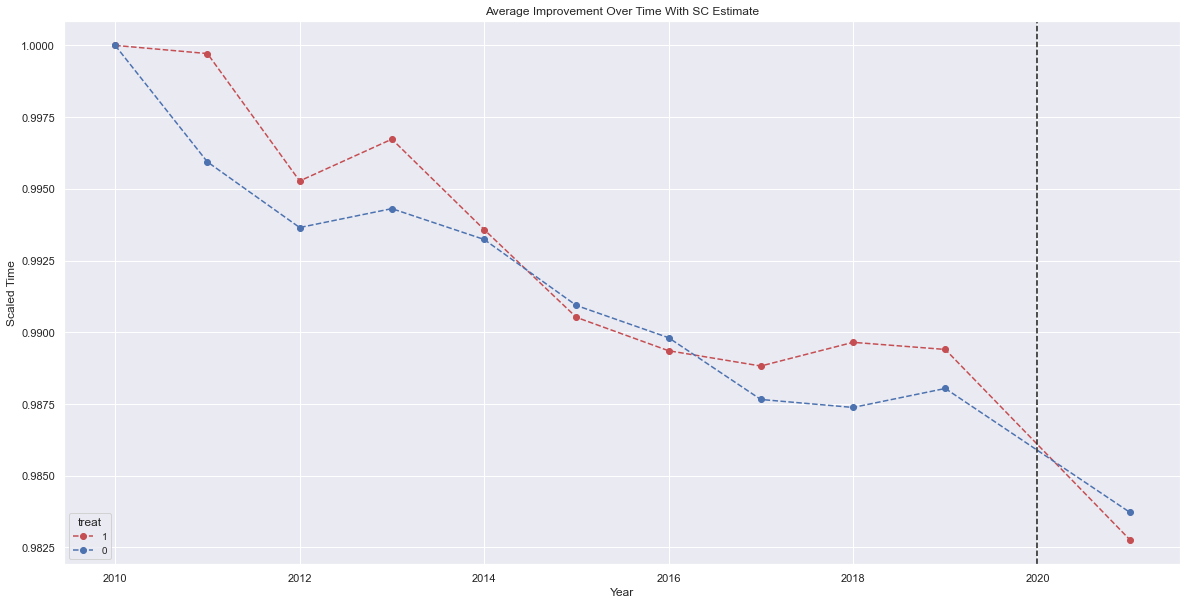

In [406]:
# plot scaled trends for synthetic control and averaged treated
t = []

for group in treat_df.groupby('CHAMP_YEAR'):
    t.append([group[0], group[1]['TIME_SECS_SCALED'].mean()])

t_df = pd.DataFrame(t, columns=['CHAMP_YEAR', 'AVG_SCALED_SECS'])

treat = plt.plot(t_df['CHAMP_YEAR'], t_df['AVG_SCALED_SECS'], '--o', color='r')
control = plt.plot(sc['CHAMP_YEAR'], sc['AVG_SCALED_SECS'], '--o', color='b')
plt.axvline(x=2020, color='k', linestyle = '--', label='Treatment')
plt.title('Average Improvement Over Time With SC Estimate')
plt.xlabel('Year')
plt.ylabel('Scaled Time')
plt.legend([1,0], loc='lower left', title='treat', prop={'size': 10})
plt.rcParams['figure.figsize'] = [20,10]

plt.show()

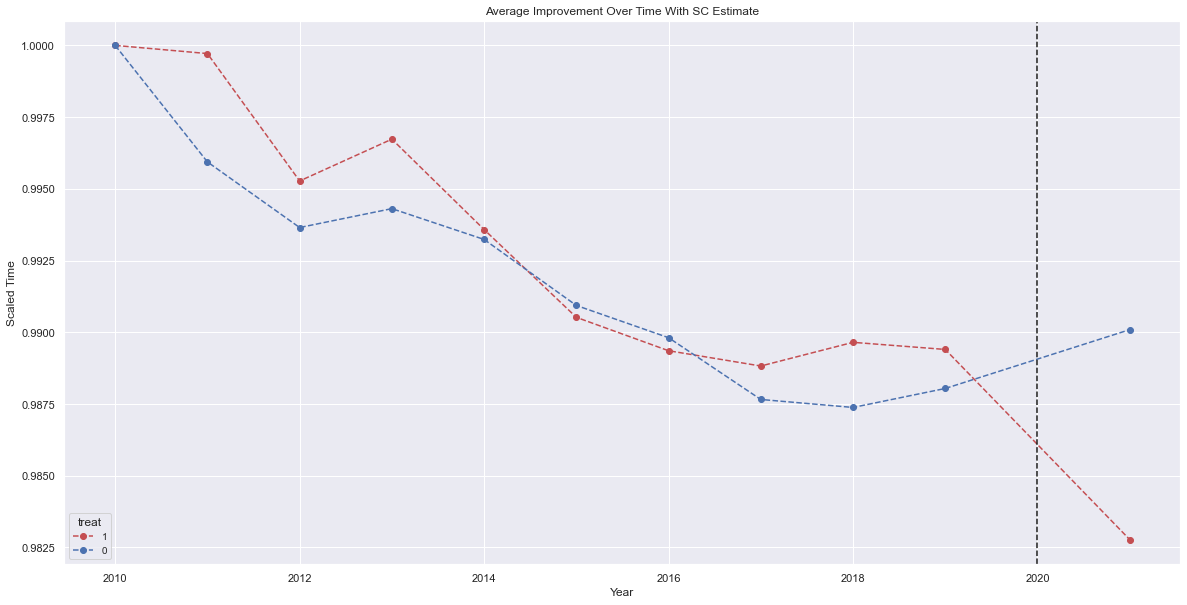

In [407]:
# plot scaled trends for synthetic control and averaged treated
t = []
c = []

for group in treat_df.groupby('CHAMP_YEAR'):
    t.append([group[0], group[1]['TIME_SECS_SCALED'].mean()])

for group in control_df.groupby('CHAMP_YEAR'):
    c.append([group[0], group[1]['TIME_SECS_SCALED'].mean()])

t_df = pd.DataFrame(t, columns=['CHAMP_YEAR', 'AVG_SCALED_SECS'])
c_df = pd.DataFrame(c, columns=['CHAMP_YEAR', 'AVG_SCALED_SECS'])

treat = plt.plot(t_df['CHAMP_YEAR'], t_df['AVG_SCALED_SECS'], '--o', color='r')
control = plt.plot(c_df['CHAMP_YEAR'], c_df['AVG_SCALED_SECS'], '--o', color='b')
plt.axvline(x=2020, color='k', linestyle = '--', label='Treatment')
plt.title('Average Improvement Over Time With SC Estimate')
plt.xlabel('Year')
plt.ylabel('Scaled Time')
plt.legend([1,0], loc='lower left', title='treat', prop={'size': 10})
plt.rcParams['figure.figsize'] = [20,10]

plt.show()

In [397]:
#update all 2021 values of TIME_SECS_SCALED with prediction from SC

df_scaled_SC = df_scaled.copy()

# df_scaled_SC.loc[df_scaled_SC.CHAMP_YEAR == 2021, 'TIME_SECS_SCALED'] = pred

In [398]:
df_scaled_SC

CHAMP_YEAR DIVISION EVENT    SEX  TIME_SECS_AVG  TIME_SECS_SCALED  TREAT  \
0          2010       D1   100    Men        10.3757          1.000000      0   
1          2011       D1   100    Men        10.3272          0.995326      0   
2          2012       D1   100    Men        10.3192          0.994555      0   
3          2013       D1   100    Men        10.3453          0.997070      0   
4          2014       D1   100    Men        10.3080          0.993475      0   
..          ...      ...   ...    ...            ...               ...    ...   
523        2016       D2   800  Women       132.4452          0.982555      1   
524        2017       D2   800  Women       131.7400          0.977324      1   
525        2018       D2   800  Women       132.3826          0.982091      1   
526        2019       D2   800  Women       132.3601          0.981924      1   
527        2021       D2   800  Women       133.3813          0.989500      1   

     AFTER  TREAT_AFTER  
0    False            0  
1    False            0  
2    False            0  
3    False            0  
4    False            0  
..     ...          ...  
523  False            0  
524  False            0  
525  False            0  
526  False            0  
527   True            1  

[528 rows x 9 columns]

In [399]:
df_scaled_SC[(df_scaled_SC['EVENT'].isin(distance_events))].loc[df_scaled_SC.CHAMP_YEAR == 2021]['TIME_SECS_SCALED']

32     0.984976
43     0.975977
76     0.986501
87     0.979420
120    0.987970
131    0.966032
230    0.985718
241    0.975470
252    0.995027
263    0.984848
296    0.972892
307    0.987740
340    0.979677
351    0.983819
384    0.983243
395    0.987355
494    0.973804
505    0.985383
516    0.990088
527    0.989500
Name: TIME_SECS_SCALED, dtype: float64

In [400]:
df_scaled_SC

CHAMP_YEAR DIVISION EVENT    SEX  TIME_SECS_AVG  TIME_SECS_SCALED  TREAT  \
0          2010       D1   100    Men        10.3757          1.000000      0   
1          2011       D1   100    Men        10.3272          0.995326      0   
2          2012       D1   100    Men        10.3192          0.994555      0   
3          2013       D1   100    Men        10.3453          0.997070      0   
4          2014       D1   100    Men        10.3080          0.993475      0   
..          ...      ...   ...    ...            ...               ...    ...   
523        2016       D2   800  Women       132.4452          0.982555      1   
524        2017       D2   800  Women       131.7400          0.977324      1   
525        2018       D2   800  Women       132.3826          0.982091      1   
526        2019       D2   800  Women       132.3601          0.981924      1   
527        2021       D2   800  Women       133.3813          0.989500      1   

     AFTER  TREAT_AFTER  
0    False            0  
1    False            0  
2    False            0  
3    False            0  
4    False            0  
..     ...          ...  
523  False            0  
524  False            0  
525  False            0  
526  False            0  
527   True            1  

[528 rows x 9 columns]

In [409]:
#Model the DiD specification with SC Observed

X = sm.add_constant(df_scaled[['TREAT', 'TREAT_AFTER', 'AFTER']].astype('float'))
y = df_scaled['TIME_SECS_SCALED']

smf_fit = smf.ols('TIME_SECS_SCALED ~ 1 + TREAT + TREAT_AFTER + AFTER', df_scaled).fit()

print(smf_fit.summary())

                            OLS Regression Results                            
Dep. Variable:       TIME_SECS_SCALED   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     17.50
Date:                Fri, 01 Oct 2021   Prob (F-statistic):           7.71e-11
Time:                        15:50:27   Log-Likelihood:                 1920.7
No. Observations:                 528   AIC:                            -3833.
Df Residuals:                     524   BIC:                            -3816.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9921      0.000   2597.668

## Interpretation: Treatment(super shoes) are associated with running 0.45% of 2010 average time seconds faster.

In [410]:
effect = -0.0085
results = []
for group in df_scaled.groupby(['DIVISION', 'EVENT', 'SEX']):
    if group[0][1] in distance:
        group[1].reset_index(inplace=True)
        results.append([group[0], effect*group[1]['TIME_SECS_AVG'][0]])
        
results = pd.DataFrame(results, columns=['GROUP', 'SECONDS_FASTER'])
results['SECONDS_FASTER'] = results['SECONDS_FASTER']*(-1)
results[['DIVISION', 'EVENT', 'SEX']] = pd.DataFrame(results['GROUP'].tolist(), index=results.index)
results = results[['DIVISION', 'EVENT', 'SEX', 'SECONDS_FASTER']]

# range of average improvement depending on DIVISION/SEX for each event
results = results.groupby(['EVENT']).agg({'SECONDS_FASTER': [np.min,np.max]}).sort_values('EVENT', ascending=False)
results

SECONDS_FASTER           
                amin       amax
EVENT                          
800         0.926032   1.145772
5000        7.087694   8.865295
3000S       4.538753   5.780146
1500        1.900937   2.355025
10000      14.947061  19.012713